In [42]:
# Ініціалізація бібліотек, налаштування seed для відтворюваності та вибір пристрою
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, BertTokenizerFast,AdamW, RobertaTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import json
import pickle
import os
from torch.amp import GradScaler, autocast
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


Using device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\geras.VADYM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geras.VADYM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\geras.VADYM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
# Функція попередньої обробки тексту
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    processed_text = ' '.join(tokens)
    
    return processed_text

def output_label(n):
    return "Fake News" if n == 0 else "Not A Fake News"


In [ ]:
# Завантаження та підготовка даних
def load_data():
    try:
        data_fake = pd.read_csv('News_dataset/Fake.csv')
        data_true = pd.read_csv('News_dataset/True.csv')
    except FileNotFoundError as e:
        print(f"Error: Dataset files not found. Please check the path. {e}")
        return None, None
    
    data_fake["class"] = 0
    data_true['class'] = 1
    
    data_fake_manual_testing = data_fake.tail(10)
    for i in range(23480, 23470, -1):
        data_fake.drop([i], axis=0, inplace=True)
    data_true_manual_testing = data_true.tail(10)
    for i in range(21416, 21406, -1):
        data_true.drop([i], axis=0, inplace=True)
        
    data_fake_manual_testing['class'] = 0
    data_true_manual_testing['class'] = 1
    manual_testing_set = pd.concat([data_fake_manual_testing, data_true_manual_testing], axis=0)
    output_dir = 'testing_data'
    os.makedirs(output_dir, exist_ok=True)
    manual_testing_set.to_csv(f'{output_dir}/manual_testing_set.csv', index=False)

    data_merge = pd.concat([data_fake, data_true], axis=0)
    data = data_merge.drop(['title', 'subject', 'date'], axis=1)
    data = data.sample(frac=1, random_state=42)
    data.reset_index(inplace=True)
    data.drop(['index'], axis=1, inplace=True)

    data['text'] = data['text'].apply(text_preprocessing)
    
    return data

print("Loading data...")
data = load_data()
print("Data loaded successfully.")


In [45]:
# Розділення даних на тренувальний і тестовий набори
def split_data(data, test_size=0.25, random_state=42):
    x = data['text']
    y = data['class']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, stratify=y, random_state=random_state
    )
    return x_train, x_test, y_train, y_test

print("Splitting data for all models...")
x_train, x_test, y_train, y_test = split_data(data, test_size=0.25, random_state=42)


Splitting data for all models...


In [46]:
# Підготовка даних для традиційних ML моделей
def prepare_ml_data(x_train, x_test, max_features=5000, max_words=256):
    vectorizer = TfidfVectorizer(max_features=max_features, max_df=0.95, min_df=2, ngram_range=(1, 2))
    xv_train = vectorizer.fit_transform(x_train.apply(lambda x: ' '.join(x.split()[:max_words])))
    xv_test = vectorizer.transform(x_test.apply(lambda x: ' '.join(x.split()[:max_words])))
    
    return xv_train, xv_test, vectorizer

print("Preparing data for traditional ML models...")
xv_train, xv_test, vectorizer = prepare_ml_data(x_train, x_test)
print("Data preparation for ML models completed.")


Preparing data for traditional ML models...
Data preparation for ML models completed.


In [47]:
# Підготовка даних для DL моделей (CNN, BiLSTM)
def prepare_dl_data(x_train, x_test, y_train, y_test, embedding_type='glove', max_length=256, batch_size=32):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x_train.tolist())
    vocab_size = len(tokenizer.word_index) + 1
    
    train_sequences = tokenizer.texts_to_sequences(x_train.tolist())
    test_sequences = tokenizer.texts_to_sequences(x_test.tolist())
    
    train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding='post')
    test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length, padding='post')
    
    train_seq = torch.tensor(train_padded, dtype=torch.long)
    test_seq = torch.tensor(test_padded, dtype=torch.long)
    train_y = torch.tensor(y_train.tolist(), dtype=torch.long)
    test_y = torch.tensor(y_test.tolist(), dtype=torch.long)
    
    train_data = TensorDataset(train_seq, train_y)
    test_data = TensorDataset(test_seq, test_y)
    
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)
    
    embedding_matrix = None
    embedding_dim = 100
    
    if embedding_type.lower() == 'glove':
        print("Loading GloVe embeddings...")
        embedding_dim = 100
        embeddings_index = {}
        
        try:
            with open('glove6b/glove.6B.100d.txt', encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
        except FileNotFoundError:
            print("Error: GloVe embeddings file not found. Using random embeddings.")
            embedding_type = 'none'
        
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    return train_dataloader, test_dataloader, vocab_size, tokenizer, test_y, test_data, embedding_matrix, embedding_dim

dl_train_dataloader, dl_test_dataloader, vocab_size, dl_tokenizer, dl_test_y, dl_test_data, embedding_matrix, embedding_dim = prepare_dl_data(
    x_train, x_test, y_train, y_test, embedding_type='glove'
)
print("Data preparation for DL models completed.")


Loading GloVe embeddings...
Data preparation for DL models completed.


In [48]:
# Підготовка даних для моделей на основі рансформерів (BERT, RoBERTa)
def prepare_transformer_data(x_train, x_test, y_train, y_test, model_type='bert', max_length=128, batch_size=16):
    if model_type.lower() == 'bert':
        tokenizer = BertTokenizerFast.from_pretrained('google-bert/bert-base-uncased')
    elif model_type.lower() == 'roberta':
        tokenizer = RobertaTokenizerFast.from_pretrained('FacebookAI/roberta-base')
    else:
        raise ValueError("Supported models are 'bert' and 'roberta' only")
    
    tokens_train = tokenizer.batch_encode_plus(
        x_train.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    
    tokens_test = tokenizer.batch_encode_plus(
        x_test.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    
    train_seq, train_mask = tokens_train['input_ids'], tokens_train['attention_mask']
    test_seq, test_mask = tokens_test['input_ids'], tokens_test['attention_mask']
    train_y = torch.tensor(y_train.tolist())
    test_y = torch.tensor(y_test.tolist())
    
    train_data = TensorDataset(train_seq, train_mask, train_y)
    test_data = TensorDataset(test_seq, test_mask, test_y)
    
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)
    
    return train_dataloader, test_dataloader, tokenizer, test_y, test_data

print("Preparing data for BERT...")
bert_train_dataloader, bert_test_dataloader, bert_tokenizer, bert_test_y, bert_test_data = prepare_transformer_data(
    x_train, x_test, y_train, y_test, model_type='bert'
)
print("Data preparation for BERT completed.")

print("Preparing data for RoBERTa...")
roberta_train_dataloader, roberta_test_dataloader, roberta_tokenizer, roberta_test_y, roberta_test_data = prepare_transformer_data(
    x_train, x_test, y_train, y_test, model_type='roberta'
)
print("Data preparation for RoBERTa completed.")


Preparing data for BERT...
Data preparation for BERT completed.
Preparing data for RoBERTa...
Data preparation for RoBERTa completed.


In [49]:
# Визначення архітектур моделей
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

class RoBERTa_Arch(nn.Module):
    def __init__(self, roberta):
        super(RoBERTa_Arch, self).__init__()
        self.roberta = roberta
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, sent_id, mask):
        outputs = self.roberta(sent_id, attention_mask=mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        x = self.fc1(cls_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

class CNN_Arch(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, n_filters=100, filter_sizes=[3, 4, 5], output_dim=2, dropout=0.5, embedding_matrix=None):
        super(CNN_Arch, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.FloatTensor(embedding_matrix))
            self.embedding.weight.requires_grad = False
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

class BiLSTM_Arch(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=256, output_dim=2, n_layers=2, dropout=0.5, embedding_matrix=None):
        super(BiLSTM_Arch, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.FloatTensor(embedding_matrix))
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=n_layers, bidirectional=True, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)


In [ ]:
# Функція для тренування та оцінки традиційних ML моделей
def train_evaluate_ml_models(xv_train, y_train, xv_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': MultinomialNB()
    }
    results = {}
    for name, model in models.items():
        start_time = time.time()
        model.fit(xv_train, y_train)
        train_time = time.time() - start_time
        start_time = time.time()
        y_pred = model.predict(xv_test)
        inference_time = time.time() - start_time
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1': report['weighted avg']['f1-score'],
            'train_time': train_time,
            'inference_time': inference_time,
            'predictions': y_pred
        }
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
        print(f"Inference Time: {inference_time:.2f} seconds")
        print(classification_report(y_test, y_pred))

    return results


In [ ]:
# Функція для тренування та оцінки DL моделей(CNN, BiLSTM, BERT, RoBERTa)
def train_evaluate_dl_models(model, model_name, train_dataloader, test_dataloader, test_y, epochs=5, lr=2e-5, patience=3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler('cuda')
    train_losses, val_losses, epoch_times = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    def train_epoch():
        model.train()
        total_loss = 0
        start_time = time.time()
        for batch in train_dataloader:
            optimizer.zero_grad()
            with autocast('cuda'):
                if model_name in ['BERT', 'RoBERTa']:
                    sent_id, mask, labels = [b.to(device) for b in batch]
                    outputs = model(sent_id, mask)
                else:
                    text, labels = [b.to(device) for b in batch]
                    outputs = model(text)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        train_time = time.time() - start_time
        return total_loss / len(train_dataloader), train_time
    
    def evaluate_epoch():
        model.eval()
        total_loss = 0
        all_preds = []
        start_time = time.time()
        with torch.no_grad():
            for batch in test_dataloader:
                if model_name in ['BERT', 'RoBERTa']:
                    sent_id, mask, labels = [b.to(device) for b in batch]
                    outputs = model(sent_id, mask)
                else:
                    text, labels = [b.to(device) for b in batch]
                    outputs = model(text)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.detach().cpu().numpy())
        inference_time = time.time() - start_time
        return total_loss / len(test_dataloader), all_preds, inference_time
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss, train_time = train_epoch()
        val_loss, val_preds, inference_time = evaluate_epoch()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epoch_times.append(train_time)
        accuracy = accuracy_score(test_y, val_preds)
        report = classification_report(test_y, val_preds, output_dict=True)
        print(f"Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
        print(f"Inference Time: {inference_time:.2f} seconds")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            os.makedirs(f'training_results/{model_name}', exist_ok=True)
            torch.save(model.state_dict(), f'training_results/{model_name}/best_model.pt')
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    model.load_state_dict(torch.load(f'training_results/{model_name}/best_model.pt'))
    final_val_loss, final_preds, final_inference_time = evaluate_epoch()
    final_accuracy = accuracy_score(test_y, final_preds)
    final_report = classification_report(test_y, final_preds, output_dict=True)
    print(f"\nFinal {model_name} Results:")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
    print(f"Inference Time: {final_inference_time:.2f} seconds")
    print(classification_report(test_y, final_preds))

    results = {
        'model': model,
        'accuracy': final_accuracy,
        'precision': final_report['weighted avg']['precision'],
        'recall': final_report['weighted avg']['recall'],
        'f1': final_report['weighted avg']['f1-score'],
        'train_time': np.sum(epoch_times),
        'inference_time': final_inference_time,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch_times': epoch_times,
        'predictions': final_preds
    }
    
    return model, results

In [52]:
# Тренування всіх моделей
print("Training and evaluating traditional ML models...")
ml_results = train_evaluate_ml_models(xv_train, y_train, xv_test, y_test)
print("Traditional ML models completed.")

print("Training CNN model...")
cnn_model = CNN_Arch(vocab_size=vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix)
cnn_model, cnn_results = train_evaluate_dl_models(
    cnn_model, "CNN", dl_train_dataloader, dl_test_dataloader, dl_test_y, epochs=5, lr=2e-5
)

print("Training BiLSTM model...")
bilstm_model = BiLSTM_Arch(vocab_size=vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix)
bilstm_model, bilstm_results = train_evaluate_dl_models(
    bilstm_model, "BiLSTM", dl_train_dataloader, dl_test_dataloader, dl_test_y, epochs=5, lr=2e-5
)

print("Training BERT model...")
bert_base = AutoModel.from_pretrained('bert-base-uncased')
for param in bert_base.parameters():
    param.requires_grad = True
bert_model = BERT_Arch(bert_base)
bert_model, bert_results = train_evaluate_dl_models(
    bert_model, "BERT", bert_train_dataloader, bert_test_dataloader, bert_test_y, epochs=3, lr=2e-6
)

print("Training RoBERTa model...")
roberta_base = AutoModel.from_pretrained('roberta-base')
for param in roberta_base.parameters():
    param.requires_grad = True
roberta_model = RoBERTa_Arch(roberta_base)
roberta_model, roberta_results = train_evaluate_dl_models(
    roberta_model, "RoBERTa", roberta_train_dataloader, roberta_test_dataloader, roberta_test_y, epochs=3, lr=2e-6
)


Training and evaluating traditional ML models...

Logistic Regression Results:
Accuracy: 0.9879
Training Time: 0.20 seconds
Inference Time: 0.00 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5868
           1       0.99      0.99      0.99      5352

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220


Naive Bayes Results:
Accuracy: 0.9437
Training Time: 0.02 seconds
Inference Time: 0.01 seconds
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5868
           1       0.94      0.94      0.94      5352

    accuracy                           0.94     11220
   macro avg       0.94      0.94      0.94     11220
weighted avg       0.94      0.94      0.94     11220

Traditional ML models completed.
Training CNN model...

Epoch 1/5
Train loss: 0.5643 | Validation

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Train loss: 0.0599 | Validation loss: 0.0082
Accuracy: 0.9980
Training Time: 139.13 seconds
Inference Time: 21.72 seconds

Epoch 2/3
Train loss: 0.0092 | Validation loss: 0.0088
Accuracy: 0.9986
Training Time: 141.30 seconds
Inference Time: 21.56 seconds

Epoch 3/3
Train loss: 0.0064 | Validation loss: 0.0042
Accuracy: 0.9991
Training Time: 139.71 seconds
Inference Time: 21.80 seconds

Final RoBERTa Results:
Accuracy: 0.9991
Average Epoch Time: 140.05 seconds
Inference Time: 21.73 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5868
           1       1.00      1.00      1.00      5352

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220



In [60]:
# Збереження моделей і допоміжних даних
def save_model(model, model_type, model_name):
    model_dir = f'training_results/{model_name}'
    os.makedirs(model_dir, exist_ok=True)
    
    if model_type == 'ml':
        with open(f'{model_dir}/{model_name}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f"{model_name} successfully saved.")
    elif model_type in ['dl', 'transformer']:
        torch.save(model.state_dict(), f'{model_dir}/{model_name}_state.pt')
        print(f"{model_name} (state) successfully saved.")

def save_auxiliary_data(data, data_name, model_type):
    if model_type == 'ml':
        aux_dir = 'training_results/auxiliary_data_ml'
    elif model_type == 'dl':
        aux_dir = 'training_results/auxiliary_data_dl'
    elif model_type == 'transformer':
        aux_dir = 'training_results/auxiliary_data_transformers'
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    os.makedirs(aux_dir, exist_ok=True)
    with open(f'{aux_dir}/{data_name}.pkl', 'wb') as f:
        pickle.dump(data, f)
    print(f"{data_name} successfully saved in {aux_dir}.")


def save_training_results(results, model_name):
    model_dir = f'training_results/{model_name}'
    os.makedirs(model_dir, exist_ok=True)
    
    metrics = {
        'accuracy': results.get('accuracy', None),
        'precision': results.get('precision', None),
        'recall': results.get('recall', None),
        'f1': results.get('f1', None),
        'train_time': results.get('train_time', None),
        'inference_time': results.get('inference_time', None)
    }
    
    with open(f'{model_dir}/{model_name}_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    
    if 'train_losses' in results and 'val_losses' in results:
        history = {
            'train_losses': results['train_losses'],
            'val_losses': results['val_losses'],
            'epoch_times': results.get('epoch_times', [])
        }
        with open(f'{model_dir}/{model_name}_history.pkl', 'wb') as f:
            pickle.dump(history, f)
    
    print(f"Training results for {model_name} successfully saved.")

def load_model(model_class, model_type, model_name, state_dict_params=None):
    model_dir = f'training_results/{model_name}'
    
    if model_type == 'ml':
        with open(f'{model_dir}/{model_name}.pkl', 'rb') as f:
            model = pickle.load(f)
    elif model_type in ['dl', 'transformer']:
        model = model_class(**(state_dict_params or {}))
        model.load_state_dict(torch.load(f'{model_dir}/best_model.pt'))
        model.eval()
    return model

def load_auxiliary_data(data_name, model_type):
    if model_type == 'ml':
        aux_dir = 'training_results/auxiliary_data_ml'
    elif model_type == 'dl':
        aux_dir = 'training_results/auxiliary_data_dl'
    elif model_type == 'transformer':
        aux_dir = 'training_results/auxiliary_data_transformers'
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    with open(f'{aux_dir}/{data_name}.pkl', 'rb') as f:
        return pickle.load(f)


In [54]:
# Збереження допоміжних даних і результатів моделей
print("Saving auxiliary data...")
save_auxiliary_data(vectorizer, 'vectorizer', 'ml')
save_auxiliary_data(dl_tokenizer, 'dl_tokenizer', 'dl')
save_auxiliary_data(embedding_matrix, 'embedding_matrix', 'dl')
model_params = {'vocab_size': vocab_size, 'embedding_dim': embedding_dim}
save_auxiliary_data(model_params, 'model_params', 'dl')
save_auxiliary_data(bert_tokenizer, 'bert_tokenizer', 'transformer')
save_auxiliary_data(roberta_tokenizer, 'roberta_tokenizer', 'transformer')

print("Saving ML models and results...")
for name, model_info in ml_results.items():
    save_model(model_info['model'], 'ml', name)
    save_training_results(model_info, name)

print("Saving DL and Transformer results...")
save_training_results(cnn_results, 'CNN')
save_training_results(bilstm_results, 'BiLSTM')
save_training_results(bert_results, 'BERT')
save_training_results(roberta_results, 'RoBERTa')


print("\nAll models and auxiliary data successfully saved.")

Saving auxiliary data...
vectorizer successfully saved in training_results/auxiliary_data_ml.
dl_tokenizer successfully saved in training_results/auxiliary_data_dl.
embedding_matrix successfully saved in training_results/auxiliary_data_dl.
model_params successfully saved in training_results/auxiliary_data_dl.
bert_tokenizer successfully saved in training_results/auxiliary_data_transformers.
roberta_tokenizer successfully saved in training_results/auxiliary_data_transformers.
Saving ML models and results...
Logistic Regression successfully saved.
Training results for Logistic Regression successfully saved.
Naive Bayes successfully saved.
Training results for Naive Bayes successfully saved.
Saving DL and Transformer results...
Training results for CNN successfully saved.
Training results for BiLSTM successfully saved.
Training results for BERT successfully saved.
Training results for RoBERTa successfully saved.

All models and auxiliary data successfully saved.


Plotting comparison metrics...


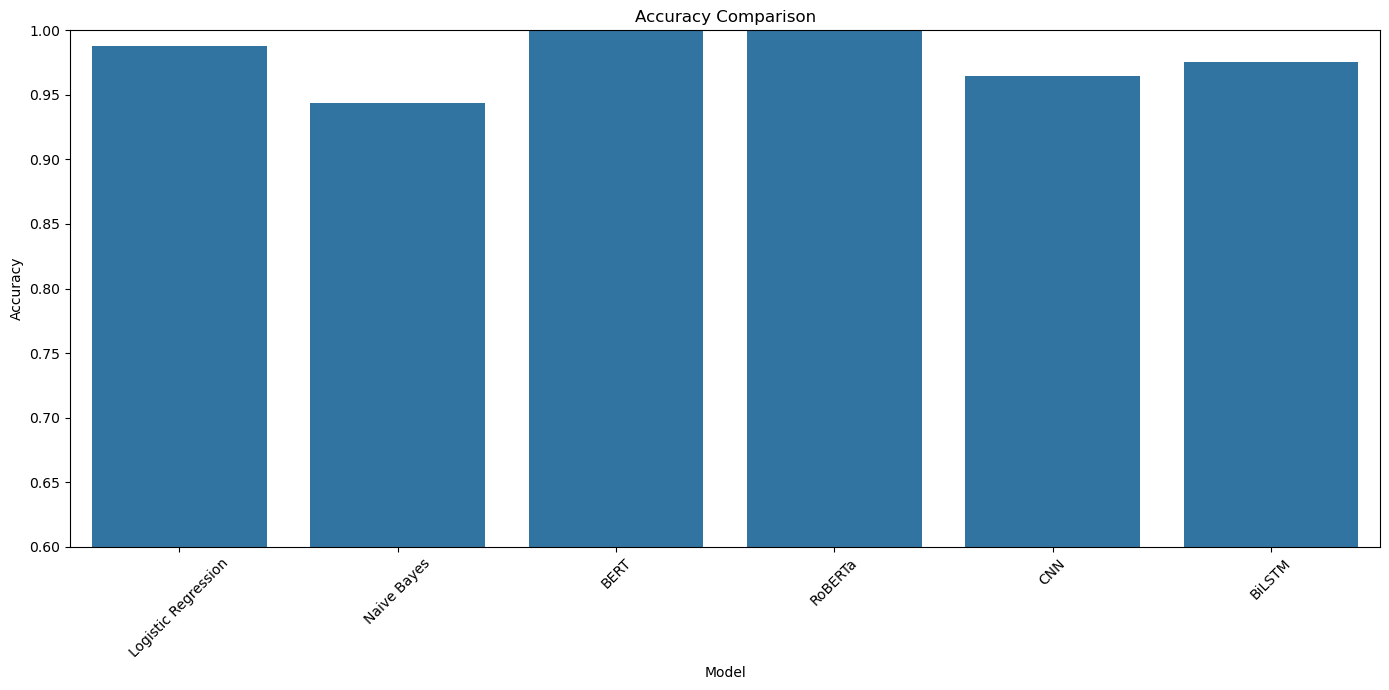

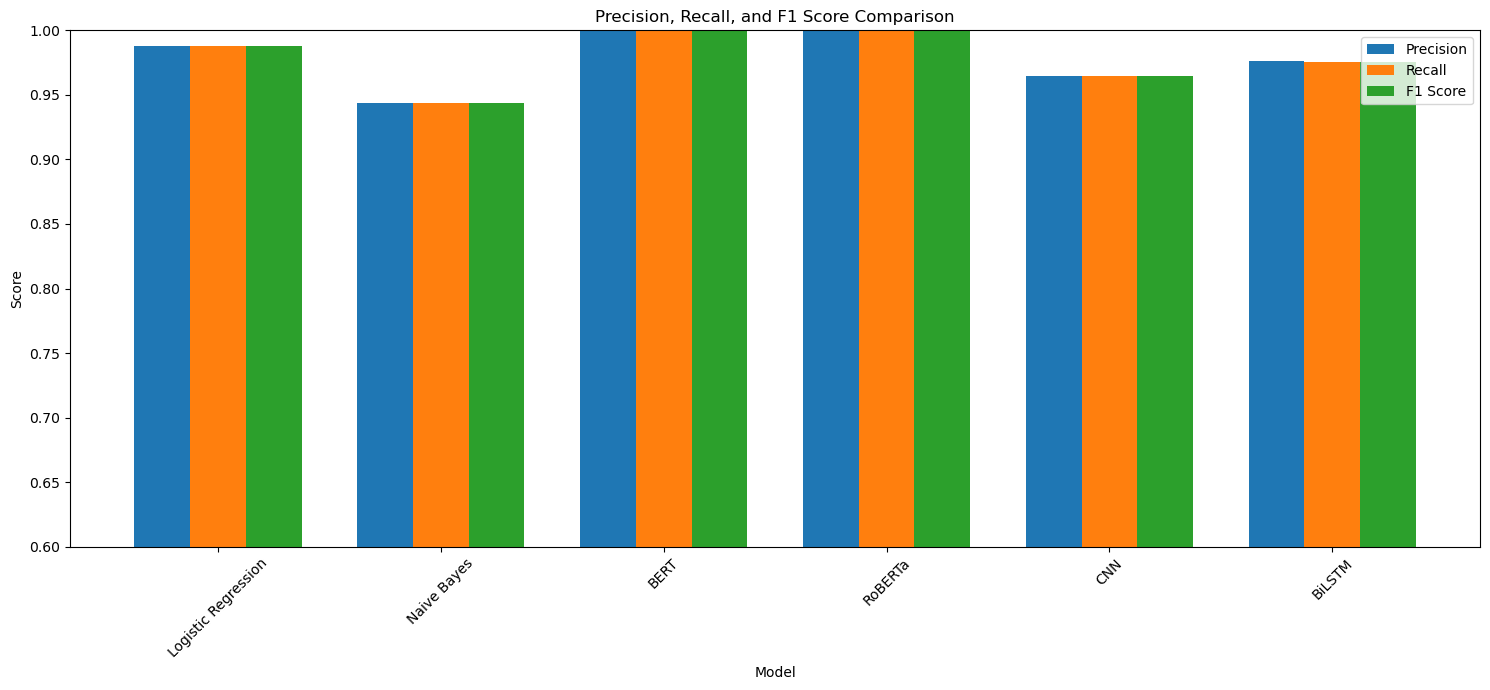

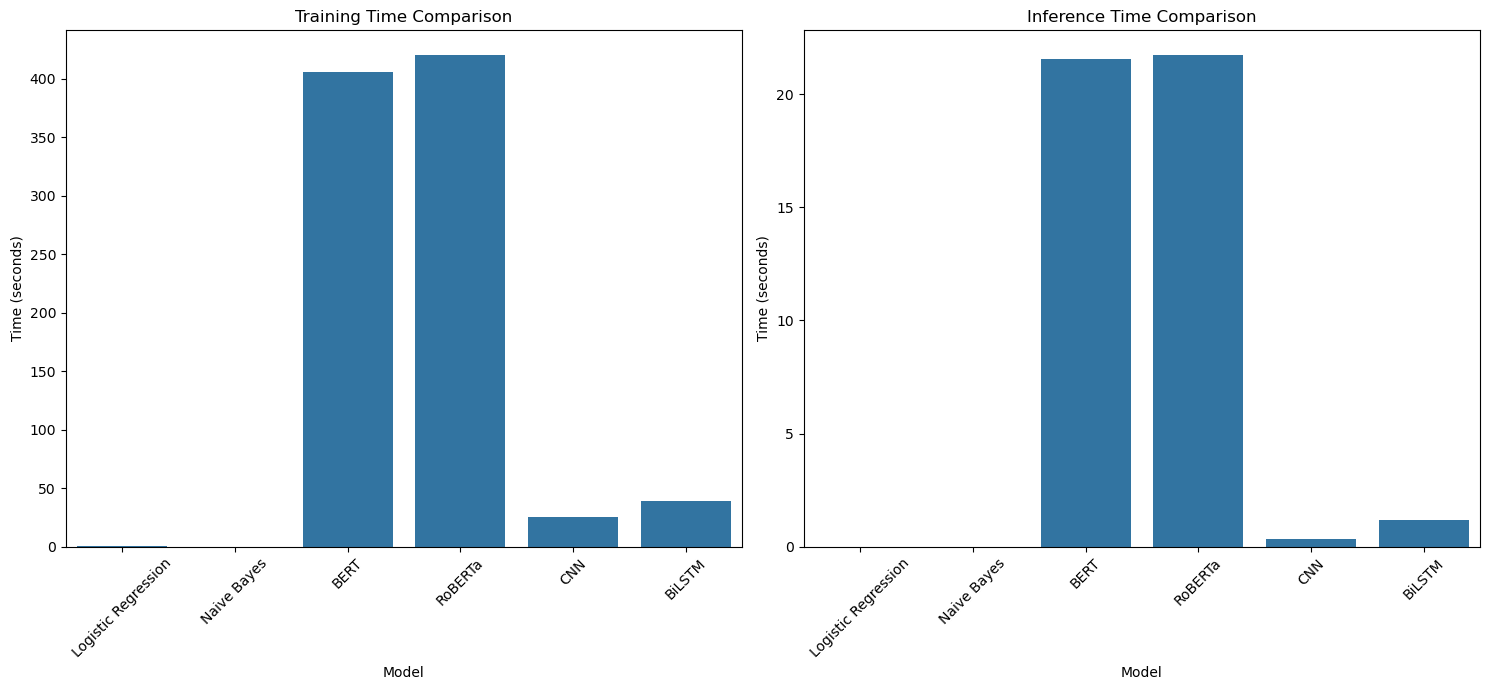

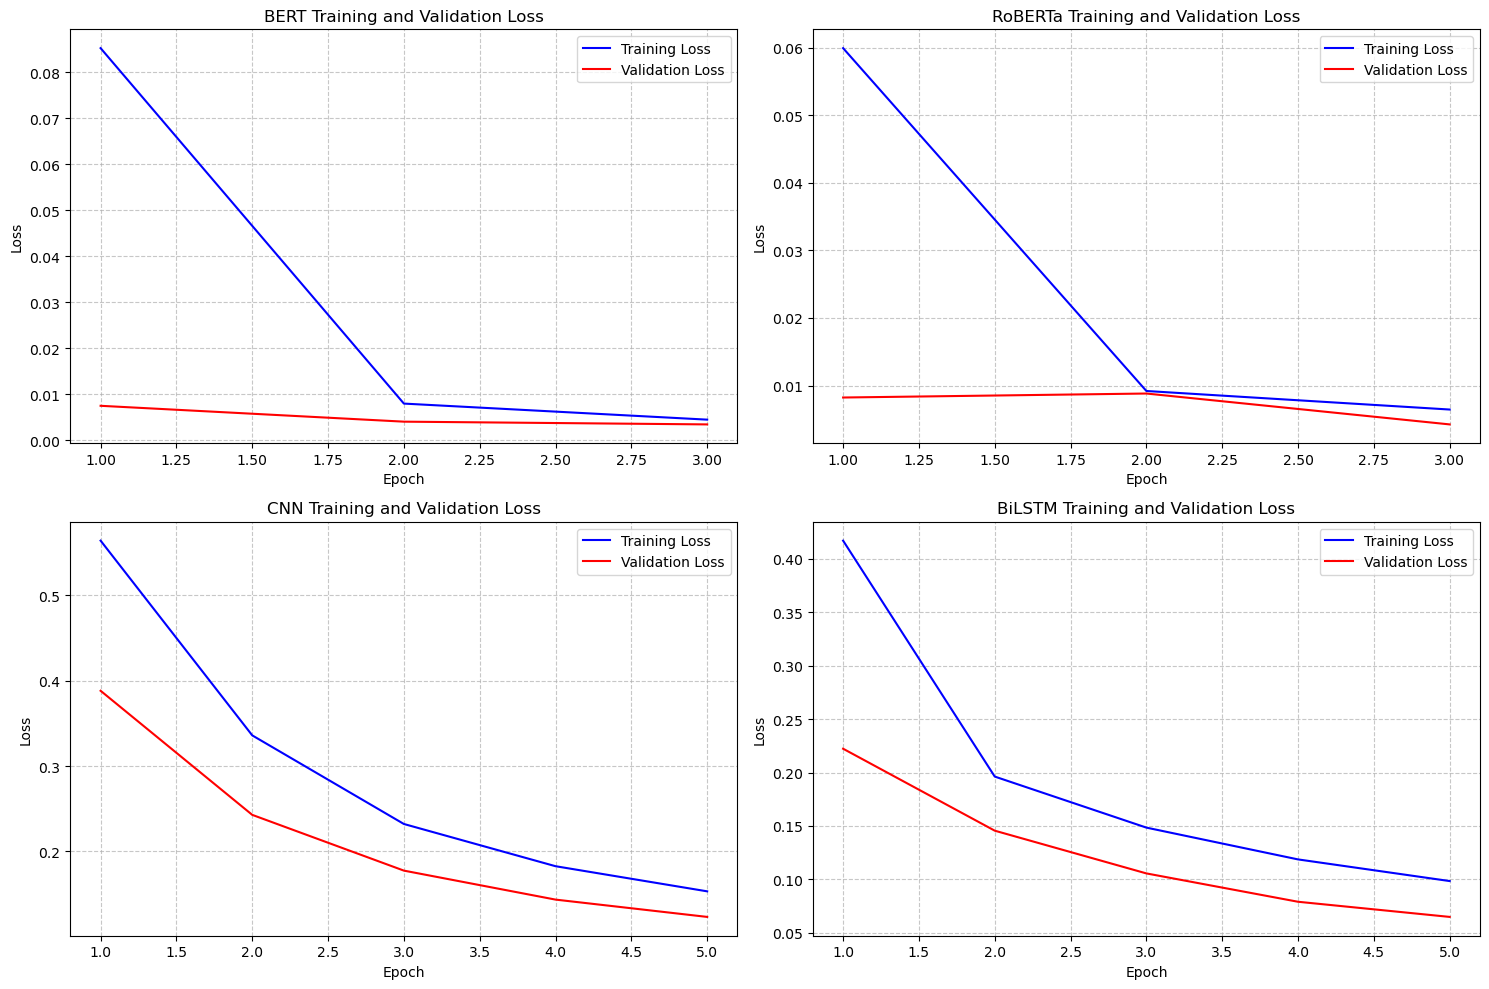

Plotting confusion matrices...


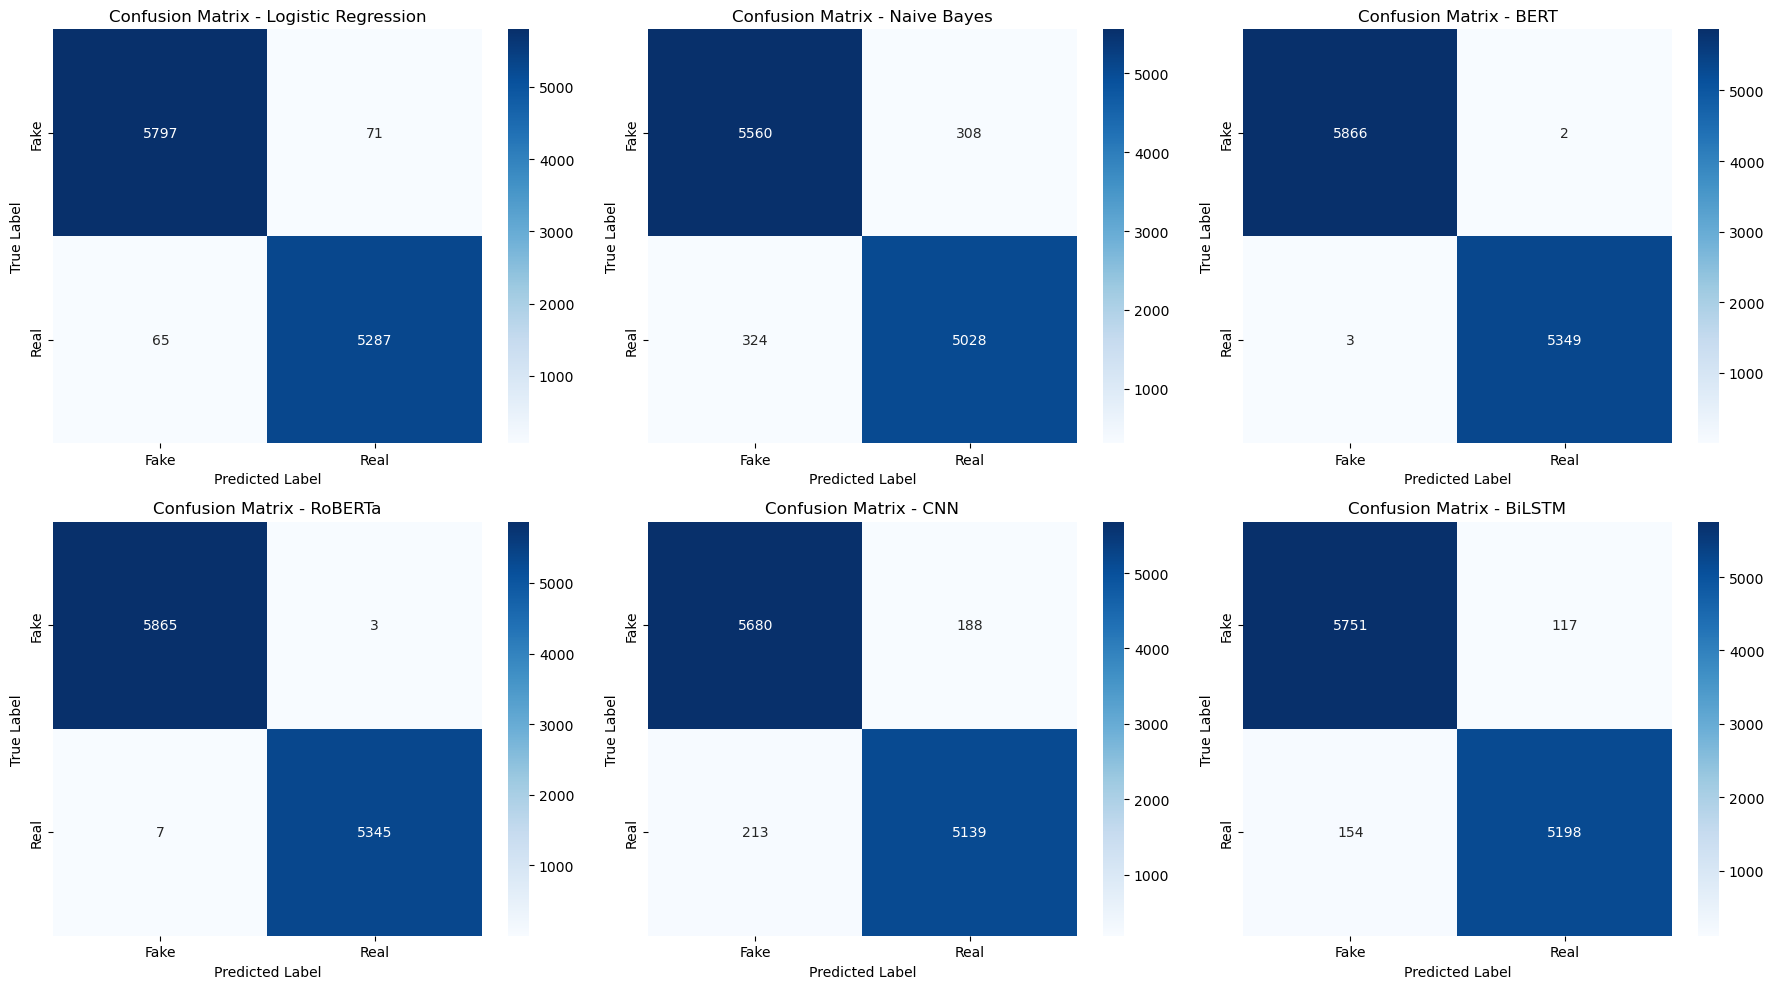

Plotting ROC curves...


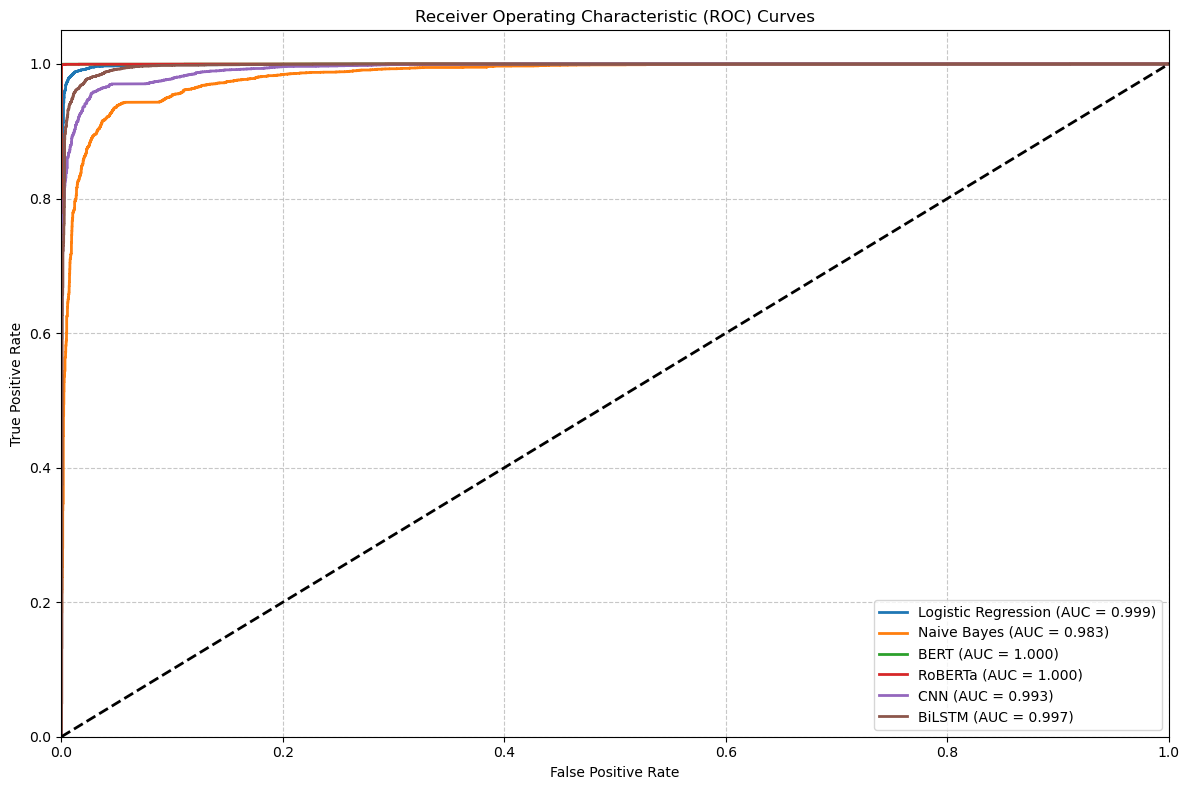

In [55]:
# Візуалізація метрик і порівняння моделей
def plot_all_metrics(all_results):
    os.makedirs('training_results/comparison_plots', exist_ok=True)
    models = list(all_results.keys())
    accuracies = [all_results[model]['accuracy'] for model in models]
    precisions = [all_results[model]['precision'] for model in models]
    recalls = [all_results[model]['recall'] for model in models]
    f1_scores = [all_results[model]['f1'] for model in models]
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x=models, y=accuracies)
    plt.ylim(0.6, 1.0)
    plt.title('Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('training_results/comparison_plots/accuracy_comparison.png')
    plt.show()
    
    plt.figure(figsize=(15, 7))
    x = np.arange(len(models))
    width = 0.25
    plt.bar(x - width, precisions, width, label='Precision')
    plt.bar(x, recalls, width, label='Recall')
    plt.bar(x + width, f1_scores, width, label='F1 Score')
    plt.ylim(0.6, 1.0)
    plt.title('Precision, Recall, and F1 Score Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_results/comparison_plots/metrics_comparison.png')
    plt.show()
    
    train_times = [all_results[model]['train_time'] for model in models]
    inference_times = [all_results[model]['inference_time'] for model in models]
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x=models, y=train_times)
    plt.title('Training Time Comparison')
    plt.xlabel('Model')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=models, y=inference_times)
    plt.title('Inference Time Comparison')
    plt.xlabel('Model')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('training_results/comparison_plots/time_comparison.png')
    plt.show()
    
    dl_models = ['BERT', 'RoBERTa', 'CNN', 'BiLSTM']
    plt.figure(figsize=(15, 10))
    
    for i, model in enumerate(dl_models):
        if model in all_results:
            plt.subplot(2, 2, i+1)
            plt.plot(range(1, len(all_results[model]['train_losses']) + 1), 
                     all_results[model]['train_losses'], 'b-', label='Training Loss')
            plt.plot(range(1, len(all_results[model]['val_losses']) + 1), 
                     all_results[model]['val_losses'], 'r-', label='Validation Loss')
            plt.title(f'{model} Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_results/comparison_plots/loss_comparison.png')
    plt.show()

def plot_all_confusion_matrices(all_results, y_test):
    models = list(all_results.keys())
    n_models = len(models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    plt.figure(figsize=(18, 5 * n_rows))
    
    for i, model_name in enumerate(models, 1):
        plt.subplot(n_rows, n_cols, i)
        cm = confusion_matrix(y_test, all_results[model_name]['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Fake', 'Real'], 
                    yticklabels=['Fake', 'Real'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('training_results/comparison_plots/conf_matrix_comparison.png')
    plt.show()

def plot_all_roc_curves(all_results, y_test, xv_test, bert_dataloader, roberta_dataloader, dl_dataloader):
    plt.figure(figsize=(12, 8))
    
    ml_models = ['Logistic Regression', 'Naive Bayes']
    for name in ml_models:
        if name in all_results:
            model_info = all_results[name]
            if hasattr(model_info['model'], 'predict_proba'):
                try:
                    y_score = model_info['model'].predict_proba(xv_test)[:, 1]
                    fpr, tpr, _ = roc_curve(y_test, y_score)
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
                except:
                    print(f"Couldn't generate ROC curve for {name}")
    
    dl_models = {'BERT': all_results.get('BERT', {}).get('model'),
                 'RoBERTa': all_results.get('RoBERTa', {}).get('model'),
                 'CNN': all_results.get('CNN', {}).get('model'),
                 'BiLSTM': all_results.get('BiLSTM', {}).get('model')}
    
    if dl_models['BERT'] is not None:
        bert_model = dl_models['BERT']
        bert_model.eval()
        bert_probs = []
        with torch.no_grad():
            for batch in bert_dataloader:
                sent_id, mask, _ = [b.to(device) for b in batch]
                outputs = bert_model(sent_id, mask)
                probs = torch.exp(outputs)[:, 1].cpu().numpy()
                bert_probs.extend(probs)
        fpr, tpr, _ = roc_curve(y_test, bert_probs[:len(y_test)])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'BERT (AUC = {roc_auc:.3f})')
    
    if dl_models['RoBERTa'] is not None:
        roberta_model = dl_models['RoBERTa']
        roberta_model.eval()
        roberta_probs = []
        with torch.no_grad():
            for batch in roberta_dataloader:
                sent_id, mask, _ = [b.to(device) for b in batch]
                outputs = roberta_model(sent_id, mask)
                probs = torch.exp(outputs)[:, 1].cpu().numpy()
                roberta_probs.extend(probs)
        fpr, tpr, _ = roc_curve(y_test, roberta_probs[:len(y_test)])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'RoBERTa (AUC = {roc_auc:.3f})')
    
    for name in ['CNN', 'BiLSTM']:
        if dl_models[name] is not None:
            model = dl_models[name]
            model.eval()
            dl_probs = []
            with torch.no_grad():
                for batch in dl_dataloader:
                    text, _ = [b.to(device) for b in batch]
                    outputs = model(text)
                    probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                    dl_probs.extend(probs)
            fpr, tpr, _ = roc_curve(y_test, dl_probs[:len(y_test)])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('training_results/comparison_plots/roc_curves.png')
    plt.show()

all_results = ml_results.copy()
all_results.update({
    'BERT': bert_results,
    'RoBERTa': roberta_results,
    'CNN': cnn_results,
    'BiLSTM': bilstm_results
})

print("Plotting comparison metrics...")
plot_all_metrics(all_results)

print("Plotting confusion matrices...")
plot_all_confusion_matrices(all_results, y_test)

print("Plotting ROC curves...")
plot_all_roc_curves(all_results, y_test, xv_test, bert_test_dataloader, roberta_test_dataloader, dl_test_dataloader)
